In [1]:
# Maximum Mean Discrepancy - Distance between two distributions, is the distance between mean of those two distributions

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torchvision
import numpy as np
from scipy.spatial.distance import cdist

In [4]:
# Training Images

import os
root = 'data_faces/img_align_celeba'
timg_list = os.listdir(root)
print(len(timg_list))

202599


In [5]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
import PIL.Image as Image
import torch
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
""" data """
crop_size = 108
re_size = 32
offset_height = (218 - crop_size) // 2
offset_width = (178 - crop_size) // 2
crop = lambda x: x[:, offset_height:offset_height + crop_size, offset_width:offset_width + crop_size]

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(crop),
     transforms.ToPILImage(),
     transforms.Scale(size=(re_size, re_size), interpolation=Image.BICUBIC),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)])

batch_size = 64


# Transformed Training Images
celeba_data = datasets.ImageFolder('./data_faces', transform=transform)

ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:219: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [6]:
# Generated Images

import os
root = 'sep_images_folder/sep_imgs'
gimg_list = os.listdir(root)
print(len(gimg_list))

6400


In [8]:
generated_transform = transforms.Compose([transforms.ToTensor()])
generated_celeb_data = datasets.ImageFolder('./sep_images_folder', transform = generated_transform)

In [9]:
batch_size = 64
nworkers = 4 

# Training Dataloader
training_data_loader = DataLoader(celeba_data, batch_size=batch_size, shuffle=True, num_workers=nworkers)

# Generated Images DataLoader
generated_data_loader = DataLoader(generated_celeb_data, batch_size=batch_size, shuffle=True, num_workers=nworkers)

In [10]:
# Encoder and Decoder Network

import torch.nn as nn

class Encoder(nn.Module):
  def __init__(self, nz):
    super().__init__()
    self.net = nn.Sequential(
        
        nn.Conv2d(3, 32, kernel_size = 4, stride = 2, padding = 1), # (B, 32 ,16, 16)
        nn.LeakyReLU(0.1),

        nn.Conv2d(32, 64, kernel_size = 4, stride = 2, padding = 1), # (B, 64, 8, 8)
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.1),

        nn.Conv2d(64 ,128, kernel_size = 4, stride = 2, padding = 0), # (B, 128, 3, 3)
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.1),

        nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 0), #(B, 256, 1, 1)
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.1),

        nn.Flatten(),
        nn.Linear(256, nz) 
    )
  
  def forward(self, x):
    return self.net(x)

class Decoder(nn.Module):
  def __init__(self, nz):
    super().__init__()
    self.map = nn.Linear(nz, 256)   # for initial Linear layer
    self.net = nn.Sequential(

        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.1),
        nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 1, padding = 0), 

        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.1),
        nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 0),  

        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.1),
        nn.ConvTranspose2d(64, 32, kernel_size = 4, stride = 2, padding = 1),  

        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.1),
        nn.ConvTranspose2d(32, 3, kernel_size = 4, stride = 2, padding = 1),  

        nn.Sigmoid()
    )
  
  def forward(self, x):
    return self.net(self.map(x).reshape(-1, 256, 1, 1))

In [11]:
nz = 64  # dimensionality of the learned embedding
encoder = Encoder(nz)
decoder = Decoder(nz)
for sample_img, sample_label in training_data_loader:
  enc = encoder(sample_img)
  print("Shape of encoding vector (should be [batch_size, nz]): {}".format(enc.shape))
  dec = decoder(enc)
  print("Shape of decoded image (should be [batch_size, 3, 32, 32]): {}".format(dec.shape))    
  break

Shape of encoding vector (should be [batch_size, nz]): torch.Size([64, 64])
Shape of decoded image (should be [batch_size, 3, 32, 32]): torch.Size([64, 3, 32, 32])


In [12]:
class AutoEncoder(nn.Module):
  def __init__(self, nz):
    super().__init__()
    self.encoder = Encoder(nz)
    self.decoder = Decoder(nz)

  def forward(self, x):
    return self.decoder(self.encoder(x))

  def reconstruct(self, x):
    """Only used later for visualization."""
    return self.forward(x)

  def encode(self, x):
    return self.encoder(x)

In [13]:
epochs = 9
learning_rate = 5e-4

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')   
ae_model = AutoEncoder(nz).to(device)    
ae_model = ae_model.train()  

opt = torch.optim.Adam(ae_model.parameters(), lr=learning_rate) # optimizer instance
criterion = nn.MSELoss()       

In [14]:
ae_model.load_state_dict(torch.load('./MMD_autoencoder.pkl'))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


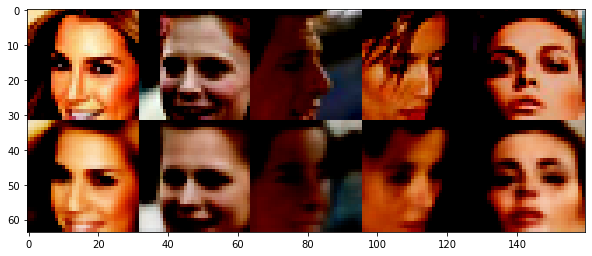

In [15]:
# visualize test data reconstructions
def vis_reconstruction(model):
  
  celeba_data_iter = iter(celeba_data) 
  model.eval()      
  input_imgs, test_reconstructions = [], []
  for _ in range(5):
    input_img = np.asarray(next(celeba_data_iter)[0])
    reconstruction = model.reconstruct(torch.tensor(input_img[None], device=device))
    input_imgs.append(np.transpose(input_img,(1,2,0)))
    test_reconstructions.append(np.transpose(reconstruction[0].data.cpu().numpy(),(1,2,0)))

  fig = plt.figure(figsize = (10, 25))   
  ax1 = plt.subplot(111)
  ax1.imshow(np.concatenate([np.concatenate(input_imgs, axis=1),
                            np.concatenate(test_reconstructions, axis=1)], axis=0))
  plt.show()

vis_reconstruction(ae_model)

In [16]:
# Latent Representation of Both Training Image an Generated Images.

# Generated Images
z_gen_list = []
for batch, _ in generated_data_loader:
    batch = batch.to(device)
    z_generated = ae_model.encode(batch)
    z_gen_list.append(z_generated)

z_generated = torch.cat(z_gen_list, dim=0)

In [17]:
print(z_generated.shape)

torch.Size([6400, 64])


In [18]:
# Training Images
z_train_list = []
batch_num = 0
for batch, _ in training_data_loader:
    batch_num += 1
    if batch_num == 101:
        break
    batch = batch.to(device)
    z_train = ae_model.encode(batch)
    z_train_list.append(z_train)

z_train = torch.cat(z_train_list, dim=0)

In [19]:
print(z_train.shape)

torch.Size([6400, 64])


In [40]:
# MMD
def max_mean_discrepancy(x, y, B, alpha):
  xx, yy, zz = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())
  rx = (xx.diag().unsqueeze(0).expand_as(xx))
  ry = (yy.diag().unsqueeze(0).expand_as(yy))

  K = torch.exp(- alpha * (rx.t() + rx - 2*xx))
  L = torch.exp(- alpha * (ry.t() + ry - 2*yy))
  P = torch.exp(- alpha * (rx.t() + ry - 2*zz))

  beta = (1./(B*(B-1)))
  gamma = (2./(B*B)) 

  mmd =  beta * (torch.sum(K)+torch.sum(L)) - gamma * torch.sum(P)
  return mmd

In [41]:
maximum_mean_dis = max_mean_discrepancy(z_train, z_generated, 6400, 0.05)

In [42]:
print(maximum_mean_dis)

tensor(0.0008, device='cuda:0', grad_fn=<SubBackward0>)
